In [1]:
# Imported Libraries
import PIL
import cv2
import shutil
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Paths for Train, Test and Validation Data
train_path = '/kaggle/input/chest-ctscan-images/Data/train'
test_path = '/kaggle/input/chest-ctscan-images/Data/test'
val_path = '/kaggle/input/chest-ctscan-images/Data/valid'

# **Simple CNN Overview**

**Preprocessing Image Parameters:**
1. Class Names = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
2. Color Mode = grayscale (1)
3. Batches are default to 32
4. Label_mode is INT
5. Based on Label mode of INT, need to use sparse_categorical_crossentropy

**CNN Model Parameters**
1. Sequential Model consisting of 3 convolution blocks (Conv2D) with a max pooling layer (MaxPooling2D) in each.
2. Fully connected layer (Dense) with 128 units on top and activated by a ReLu activation.
3. Adam Optimizer used which is a SGD method based on adaptive Estimation of first-order and second-order moments.
4. Began with 10 epochs as a base

**Output**
1. Visualized training versus validation for accuracy over the 10 epochs
2. Visualized training versus validation for loss over the 10 epochs
3. Applied simple CNN to predict test data. 

In [3]:
# Loading Data using Keras Utility

train_ds = tf.keras.utils.image_dataset_from_directory(train_path, class_names=['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib' \
                                                                             , 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa' \
                                                                             , 'normal' \
                                                                             , 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'], color_mode ='grayscale')

test_ds = tf.keras.utils.image_dataset_from_directory(test_path, class_names=['adenocarcinoma' \
                                                                             , 'large.cell.carcinoma' \
                                                                             , 'normal' \
                                                                             , 'squamous.cell.carcinoma'], color_mode = 'grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(val_path, class_names=['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib' \
                                                                             , 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa' \
                                                                             , 'normal' \
                                                                             , 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'], color_mode = 'grayscale')


Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.


In [4]:
# Viewing Class Names
class_names = test_ds.class_names
print(class_names)

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


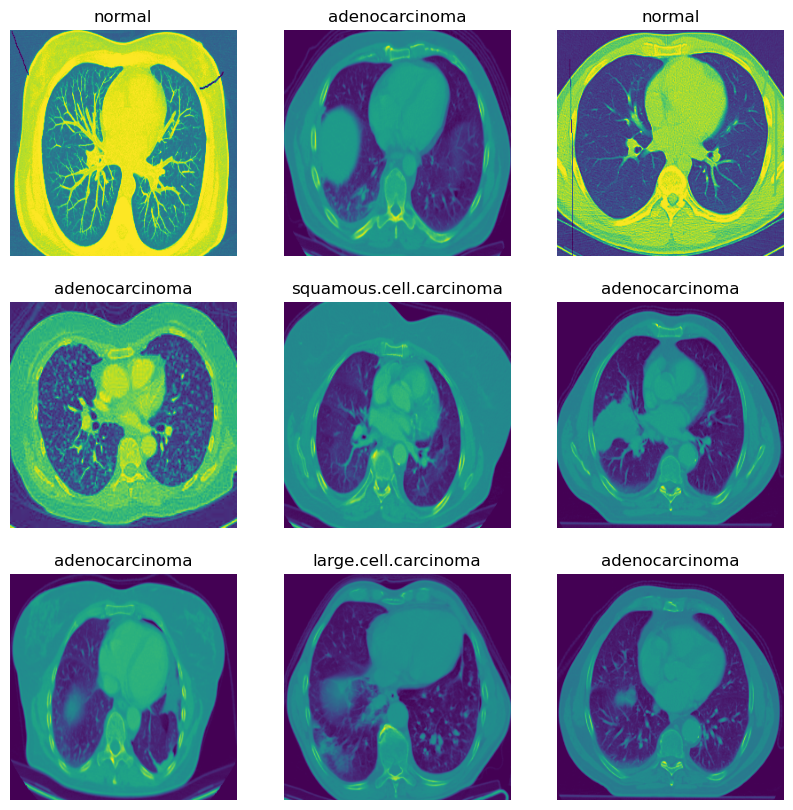

In [5]:
# Visualizing the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [6]:
# Viewing tensor of shape 32, 256, 256, 1
# Batch = 32
# Shape of images = 256X256 
# Color channel = 1 (grayscale)
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 1)
(32,)


In [7]:
# Configuring the dataset for performance
# Cache function keeps the images in memory after they're loaded off disk
# Prefetch overlaps data preprocessing and model execution will training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Creating the model
# Sequential model consists of 3 convolutional blocks Conv2D with a max pooling layer (maxPooling2D)
# Fully connected dense layer of with 128 units on top of it and activated by ReLu activation
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 1)),
  layers.Conv2D(16, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
# Compiling Model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [10]:
# Visualize layers of the network
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      544       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        2

In [11]:
# Training the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs = epochs)

Epoch 1/10
20/20 [==============================] - 17s 678ms/step - loss: 1.5307 - accuracy: 0.3344 - val_loss: 1.3203 - val_accuracy: 0.3611
Epoch 2/10
20/20 [==============================] - 13s 658ms/step - loss: 1.0465 - accuracy: 0.5677 - val_loss: 1.1243 - val_accuracy: 0.4444
Epoch 3/10
20/20 [==============================] - 13s 627ms/step - loss: 0.8185 - accuracy: 0.6819 - val_loss: 0.9336 - val_accuracy: 0.6389
Epoch 4/10
20/20 [==============================] - 13s 655ms/step - loss: 0.6688 - accuracy: 0.7292 - val_loss: 0.8702 - val_accuracy: 0.6528
Epoch 5/10
20/20 [==============================] - 13s 636ms/step - loss: 0.5133 - accuracy: 0.8091 - val_loss: 0.7328 - val_accuracy: 0.6389
Epoch 6/10
20/20 [==============================] - 13s 640ms/step - loss: 0.4027 - accuracy: 0.8613 - val_loss: 0.8715 - val_accuracy: 0.6389
Epoch 7/10
20/20 [==============================] - 13s 628ms/step - loss: 0.3510 - accuracy: 0.8646 - val_loss: 0.7333 - val_accuracy: 0.6389

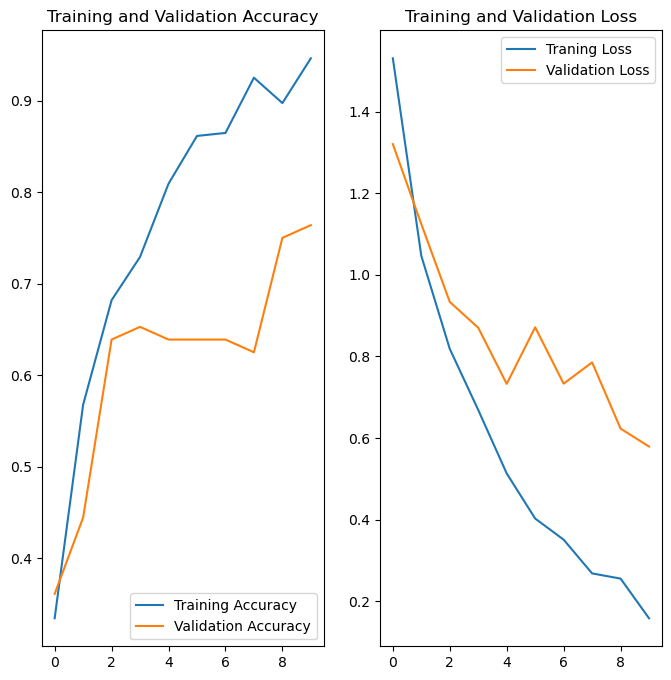

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Traning Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


10/10 [==============================] - 3s 144ms/step
This image most likely belongs to large.cell.carcinoma with a 99.00 percent confidence.


# **MobileNetV2**

# **VGG16 Model**

To Do List:
Try other Cnns: VGG16, MobileNetV2...
https://www.tensorflow.org/tutorials/images/transfer_learning